## **Short Question Answer Evaluation Using Glove And Universal Sentence Encoder**

In [ ]:
#Required Libraries

from __future__ import print_function
import numpy as np
import csv, json
from zipfile import ZipFile
from os.path import expanduser, exists
import pandas as pd
from nltk.tokenize import word_tokenize,sent_tokenize
!pip install sentence_transformers
from sentence_transformers import SentenceTransformer, util
from nltk.stem import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from matplotlib.pyplot import pie, axis, show
import matplotlib.pyplot as plt


from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.data_utils import get_file

%matplotlib inline
import datetime, time, json
from keras.models import Model
from keras.layers import Input, Bidirectional, LSTM, dot, Flatten, Dense, Reshape, add, Dropout, BatchNormalization, Conv1D
from keras.layers.embeddings import Embedding
from keras.regularizers import l2
from keras.callbacks import Callback, ModelCheckpoint
from keras import backend as K
from sklearn.model_selection import train_test_split
from keras.layers import Conv1D , MaxPooling1D, Flatten,Dense,Input,Lambda

     |████████████████████████████████| 71kB 5.4MB/s 
     |████████████████████████████████| 1.5MB 11.4MB/s 
     |████████████████████████████████| 1.2MB 30.6MB/s 
     |████████████████████████████████| 890kB 44.6MB/s 
     |████████████████████████████████| 2.9MB 55.9MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.4.1.2-cp36-none-any.whl size=103068 sha256=8a4c60e36bfc5e2a082405ca08950402dde0f6f07a3f8caaedc061693416e5e4
  Stored in directory: /root/.cache/pip/wheels/3d/33/d1/5703dd56199c09d4a1b41e0c07fb4e7765a84d787cbdc48ac3
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=351027850fb39569a92671731c977a51b0265597377ac0d28c2d74c6963f7689
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sentence-transformers sacremoses


In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
#file names for saving intermediate data and constants in the program

KERAS_DATASETS_DIR = expanduser('/')
GLOVE_ZIP_FILE_URL = 'http://nlp.stanford.edu/data/glove.840B.300d.zip'
GLOVE_ZIP_FILE = 'glove.840B.300d.zip'
GLOVE_FILE = 'glove.840B.300d.txt'
Q1_TRAINING_DATA_FILE = 'q1_train.npy'
Q2_TRAINING_DATA_FILE = 'q2_train.npy'
LABEL_TRAINING_DATA_FILE = 'label_train.npy'
WORD_EMBEDDING_MATRIX_FILE = 'word_embedding_matrix.npy'
model3 = SentenceTransformer('distilroberta-base-paraphrase-v1')
NB_WORDS_DATA_FILE = 'nb_words.json'
MAX_NB_WORDS = 200000
MAX_SEQUENCE_LENGTH = 25
EMBEDDING_DIM = 300

100%|██████████| 306M/306M [00:18<00:00, 16.4MB/s]


In [ ]:
if not exists(KERAS_DATASETS_DIR + GLOVE_ZIP_FILE):
    zipfile = ZipFile(get_file(GLOVE_ZIP_FILE, GLOVE_ZIP_FILE_URL))
    zipfile.extract(GLOVE_FILE, path=KERAS_DATASETS_DIR)
    
print("Processing", GLOVE_FILE)

embeddings_index = {}
with open(KERAS_DATASETS_DIR + GLOVE_FILE, encoding='utf-8') as f:
    for line in f:
        values = line.split(' ')
        word = values[0]
        embedding = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = embedding

print('Word embeddings: %d' % len(embeddings_index))

2176770048/2176768927 [==============================] - 1014s 0us/step
Processing glove.840B.300d.txt
Word embeddings: 2196016


#### **Loading the dataset**

In [ ]:
df = pd.read_csv('Dataset.csv')
#del df['Unnamed: 4']
df.dropna(inplace = True)   #Drop of null values from dataset

In [ ]:
#Pre-Processing Steps

import re
import string 

stemmer_ps = PorterStemmer()

#Convert to lower case
def text_lowercase(text): 
    return text.lower()

#remove numbers or digits
def remove_numbers(text): 
    result = re.sub(r'\d+', '', text) 
    return result

#remove punctuations
def remove_punctuation(text): 
    translator = str.maketrans('', '', string.punctuation) 
    return text.translate(translator)

#remove one word sentences
def one_word(text):
    temp = text.split(' ')
    if len(temp)<2:
        return float('nan')
    return text

#remove extra whitespaces
def remove_whitespace(text): 
    return  " ".join(text.split())

#remove html tags
def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>|</.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext

#Stemming
def stemSentence(sentence):
    token_words=word_tokenize(sentence) #we need to tokenize the sentence or else stemming will return the entire sentence as is.
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(stemmer_ps.stem(word))
        stem_sentence.append(" ") #adding a space so that we can join all the words at the end to form the sentence again.
    return "".join(stem_sentence)

#labelling of data
def label(text):
  if text == 'incorrect':
    return 0;
  if text == 'correct' :
    return 1;

In [ ]:
df.tail()

,Unnamed: 0,studentAnswer,referenceAnswer,ref_1,ref_2,accuracy
4920,4920,To see if the standard might be faster than th...,A standard is used for comparison to determine...,So that you can see the results of an experime...,You use a standard so you can tell what happen...,incorrect
4921,4921,Because you can compare the results.,A standard is used for comparison to determine...,So that you can see the results of an experime...,You use a standard so you can tell what happen...,incorrect
4922,4922,To help control the controlled experiment.,A standard is used for comparison to determine...,So that you can see the results of an experime...,You use a standard so you can tell what happen...,incorrect
4923,4923,To control any experiment.,A standard is used for comparison to determine...,So that you can see the results of an experime...,You use a standard so you can tell what happen...,incorrect
4924,4924,Because without a standard you will not know t...,A standard is used for comparison to determine...,So that you can see the results of an experime...,You use a standard so you can tell what happen...,incorrect


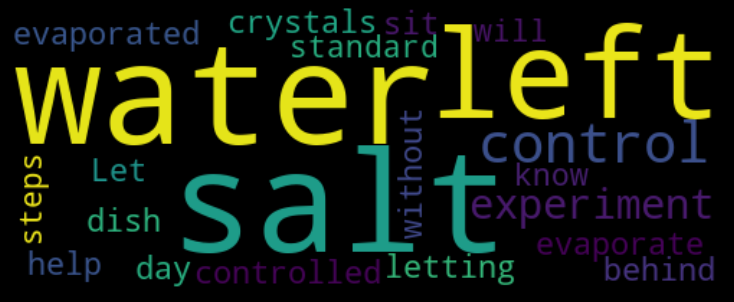

In [ ]:
#word cloud of student answers

text = df['studentAnswer'].values
wordcloud = WordCloud(
    width = 500,
    height = 200,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (10, 10),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [ ]:
# applying the pre-processing steps to all the datapoints in the dataset


df['studentAnswer'] = df['studentAnswer'].apply(lambda sen: text_lowercase(sen))
df['studentAnswer'] = df['studentAnswer'].apply(lambda sen: remove_punctuation(sen))
df['studentAnswer'] = df['studentAnswer'].apply(lambda sen: remove_whitespace(sen))
df['studentAnswer'] = df['studentAnswer'].apply(lambda sen: cleanhtml(sen))
df['studentAnswer'] = df['studentAnswer'].apply(lambda sen: stemSentence(sen))
df['referenceAnswer'] = df['referenceAnswer'].apply(lambda sen: text_lowercase(sen))
df['referenceAnswer'] = df['referenceAnswer'].apply(lambda sen: remove_punctuation(sen))
df['referenceAnswer'] = df['referenceAnswer'].apply(lambda sen: remove_whitespace(sen))
df['referenceAnswer'] = df['referenceAnswer'].apply(lambda sen: cleanhtml(sen))
df['referenceAnswer'] = df['referenceAnswer'].apply(lambda sen: stemSentence(sen))
df['ref_1'] = df['ref_1'].apply(lambda sen: text_lowercase(sen))
df['ref_1'] = df['ref_1'].apply(lambda sen: remove_punctuation(sen))
df['ref_1'] = df['ref_1'].apply(lambda sen: remove_whitespace(sen))
df['ref_1'] = df['ref_1'].apply(lambda sen: cleanhtml(sen))
df['ref_1'] = df['ref_1'].apply(lambda sen: stemSentence(sen))
df['ref_2'] = df['ref_2'].apply(lambda sen: text_lowercase(sen))
df['ref_2'] = df['ref_2'].apply(lambda sen: remove_punctuation(sen))
df['ref_2'] = df['ref_2'].apply(lambda sen: remove_whitespace(sen))
df['ref_2'] = df['ref_2'].apply(lambda sen: cleanhtml(sen))
df['ref_2'] = df['ref_2'].apply(lambda sen: stemSentence(sen))
df['label'] = df['accuracy'].apply(lambda sen: label(sen))
df

,Unnamed: 0,studentAnswer,referenceAnswer,ref_1,ref_2,accuracy,label
0,0,by let it sit in a dish for a day,the water wa evapor leav the salt,we evapor the salt from the water becaus the w...,i put some water in a dish and let the water e...,incorrect,0
1,1,let the water evapor and the salt is left behind,the water wa evapor leav the salt,we evapor the salt from the water becaus the w...,i put some water in a dish and let the water e...,correct,1
2,2,the water evapor and left salt crystal,the water wa evapor leav the salt,we evapor the salt from the water becaus the w...,i put some water in a dish and let the water e...,correct,1
3,3,i saw a pinkish grayish color that wa block th...,the water wa evapor leav the salt,we evapor the salt from the water becaus the w...,i put some water in a dish and let the water e...,incorrect,0
4,4,you have to slowli tip the vial for onli the w...,the water wa evapor leav the salt,we evapor the salt from the water becaus the w...,i put some water in a dish and let the water e...,incorrect,0
...,...,...,...,...,...,...,...
4920,4920,to see if the standard might be faster than th...,a standard is use for comparison to determin h...,so that you can see the result of an experi be...,you use a standard so you can tell what happen...,incorrect,0
4921,4921,becaus you can compar the result,a standard is use for comparison to determin h...,so that you can see the result of an experi be...,you use a standard so you can tell what happen...,incorrect,0
4922,4922,to help control the control experi,a standard is use for comparison to determin h...,so that you can see the result of an experi be...,you use a standard so you can tell what happen...,incorrect,0
4923,4923,to control ani experi,a standard is use for comparison to determin h...,so that you can see the result of an experi be...,you use a standard so you can tell what happen...,incorrect,0


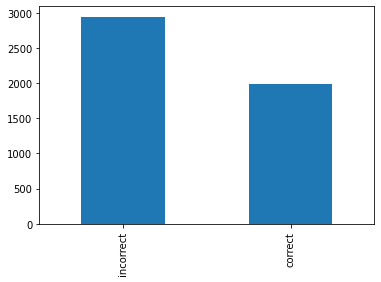

In [ ]:
#dataset split of true and false instances
df['accuracy'].value_counts(sort=True).head(10).plot.bar()

### **Expanding the dataset**

In [ ]:
dup = []
ans1 = []
ans2 = []

for i in range(len(df)) :
  try:
    if df.loc[i, "label"] == 0:
      dup.append(0)
      ans1.append(df.loc[i, "studentAnswer"])
      ans2.append(df.loc[i, "referenceAnswer"])
    if df.loc[i, "label"] == 1:
      dup.append(1)
      ans1.append(df.loc[i, "studentAnswer"])
      ans2.append(df.loc[i, "referenceAnswer"])
  except:
    continue

In [ ]:
for i in range(len(df)) :
  try:
    if df.loc[i, "label"] == 0:
      dup.append(0)
      ans1.append(df.loc[i, "studentAnswer"])
      ans2.append(df.loc[i, "ref_1"])
    if df.loc[i, "label"] == 1:
      dup.append(1)
      ans1.append(df.loc[i, "studentAnswer"])
      ans2.append(df.loc[i, "ref_1"])
  except:
    continue

for i in range(len(df)) :
  try:
    if df.loc[i, "label"] == 0:
      dup.append(0)
      ans1.append(df.loc[i, "studentAnswer"])
      ans2.append(df.loc[i, "ref_2"])
    if df.loc[i, "label"] == 1:
      dup.append(1)
      ans1.append(df.loc[i, "studentAnswer"])
      ans2.append(df.loc[i, "ref_2"])
  except:
    continue

In [ ]:
len(ans1)

14775

In [ ]:
#one-hot Encoding the target values for easy training

one_hot = pd.get_dummies(dup)
one_hot = np.array(one_hot)

In [ ]:
is_duplicate = dup

In [ ]:
question1 = ans1
question2 = ans2
is_duplicate = dup

**Glove Embeddings**

In [ ]:
questions = question1 + question2
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(questions)
question1_word_sequences = tokenizer.texts_to_sequences(question1)
question2_word_sequences = tokenizer.texts_to_sequences(question2)
word_index = tokenizer.word_index

print("Words in index: %d" % len(word_index))

Words in index: 1680


In [ ]:
nb_words = min(MAX_NB_WORDS, len(word_index))
word_embedding_matrix = np.zeros((nb_words + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > MAX_NB_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        word_embedding_matrix[i] = embedding_vector

print('Null word embeddings: %d' % np.sum(np.sum(word_embedding_matrix, axis=1) == 0))

Null word embeddings: 111


**Universal Sentence Embeddings**

In [ ]:
# Embeddings are generated from another script we have written

q1_emb = np.load('q11_emb.npy')
q2_emb = np.load('q22_emb.npy')

In [ ]:
#padding the sequences to get uniform length

q1_data = pad_sequences(question1_word_sequences, maxlen=25)
q2_data = pad_sequences(question2_word_sequences, maxlen=25)
labels = np.array(is_duplicate)
print('Shape of question1 data tensor:', q1_data.shape)
print('Shape of question2 data tensor:', q2_data.shape)
print('Shape of label tensor:', labels.shape)

Shape of question1 data tensor: (14775, 25)
Shape of question2 data tensor: (14775, 25)
Shape of label tensor: (14775,)


In [ ]:
#save the training data

np.save(open(Q1_TRAINING_DATA_FILE, 'wb'), q1_data)
np.save(open(Q2_TRAINING_DATA_FILE, 'wb'), q2_data)
np.save(open(LABEL_TRAINING_DATA_FILE, 'wb'), labels)
np.save(open(WORD_EMBEDDING_MATRIX_FILE, 'wb'), word_embedding_matrix)
with open(NB_WORDS_DATA_FILE, 'w') as f:
    json.dump({'nb_words': nb_words}, f)

In [ ]:
Q1_TRAINING_DATA_FILE = 'q1_train.npy'
Q2_TRAINING_DATA_FILE = 'q2_train.npy'
LABEL_TRAINING_DATA_FILE = 'label_train.npy'
WORD_EMBEDDING_MATRIX_FILE = 'word_embedding_matrix.npy'
NB_WORDS_DATA_FILE = 'nb_words.json'
MODEL_WEIGHTS_FILE = 'final_weights.h5'
MAX_SEQUENCE_LENGTH = 25
WORD_EMBEDDING_DIM = 300
SENT_EMBEDDING_DIM = 128
VALIDATION_SPLIT = 0.1
TEST_SPLIT = 0.1
RNG_SEED = 13371447
NB_EPOCHS = 11
DROPOUT = 0.2
BATCH_SIZE = 64

In [ ]:
q1_data = np.load(open(Q1_TRAINING_DATA_FILE, 'rb'))
q2_data = np.load(open(Q2_TRAINING_DATA_FILE, 'rb'))
labels = np.load(open(LABEL_TRAINING_DATA_FILE, 'rb'))
word_embedding_matrix = np.load(open(WORD_EMBEDDING_MATRIX_FILE, 'rb'))
with open(NB_WORDS_DATA_FILE, 'r') as f:
    nb_words = json.load(f)['nb_words']

In [ ]:
X = np.stack((q1_data, q2_data), axis=1)
#y = labels
y = one_hot
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SPLIT, random_state=RNG_SEED)
Q1_train = X_train[:,0]
Q2_train = X_train[:,1]
Q1_test = X_test[:,0]
Q2_test = X_test[:,1]

**Model**

In [ ]:
question1_a = Input(shape=(MAX_SEQUENCE_LENGTH,))
question2_a = Input(shape=(MAX_SEQUENCE_LENGTH,))

question1_b = Input(shape=(512,1))
question2_b = Input(shape=(512,1))

q1_a = Embedding(nb_words + 1, 
                 WORD_EMBEDDING_DIM, 
                 weights=[word_embedding_matrix], 
                 input_length=MAX_SEQUENCE_LENGTH, 
                 trainable=False)(question1_a)

q2_a = Embedding(nb_words + 1, 
                 WORD_EMBEDDING_DIM, 
                 weights=[word_embedding_matrix], 
                 input_length=MAX_SEQUENCE_LENGTH, 
                 trainable=False)(question2_a)
                 
q1_a = Bidirectional(LSTM(SENT_EMBEDDING_DIM, return_sequences=True), merge_mode="sum")(q1_a)

q1_b = Bidirectional(LSTM(SENT_EMBEDDING_DIM, return_sequences=True), merge_mode="sum")(q2_a)


                 
q1_b = Bidirectional(LSTM(SENT_EMBEDDING_DIM, return_sequences=True), merge_mode="sum")(question1_b)

q2_b = Bidirectional(LSTM(SENT_EMBEDDING_DIM, return_sequences=True), merge_mode="sum")(question2_b)

attention_a = dot([q1_a,q2_a], [1,1])
attention_a = Flatten()(attention_a)
attention_a = Dense((MAX_SEQUENCE_LENGTH*SENT_EMBEDDING_DIM))(attention_a)
attention_a = Reshape((MAX_SEQUENCE_LENGTH, SENT_EMBEDDING_DIM))(attention_a)

attention_b = dot([q1_b,q2_b], [1,1])
attention_b = Flatten()(attention_b)
attention_b = Dense((MAX_SEQUENCE_LENGTH*SENT_EMBEDDING_DIM))(attention_b)
attention_b = Reshape((MAX_SEQUENCE_LENGTH, SENT_EMBEDDING_DIM))(attention_b)

merged = add([attention_a,attention_b])
merged = Flatten()(merged)
merged = Dense(500, activation='relu')(merged)
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)
merged = Dense(300, activation='relu')(merged)
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)
merged = Dense(200, activation='relu')(merged)
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)
merged = Dense(200, activation='relu')(merged)
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)

is_duplicate = Dense(2, activation='sigmoid')(merged)

model = Model(inputs=[question1,question2], outputs=is_duplicate)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

**Training**

In [ ]:
print("Starting training at", datetime.datetime.now())
t0 = time.time()
callbacks = [ModelCheckpoint(MODEL_WEIGHTS_FILE, monitor='val_accuracy', save_best_only=True)]
history = model.fit([Q1_train, Q2_train],
                    y_train,
                    epochs=NB_EPOCHS,
                    validation_split=VALIDATION_SPLIT,
                    verbose=2,
                    batch_size=BATCH_SIZE,
                    callbacks=callbacks)
t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2021-01-12 04:22:47.637234
Epoch 1/11
187/187 - 12s - loss: 0.7310 - accuracy: 0.5817 - val_loss: 1.9557 - val_accuracy: 0.5812
Epoch 2/11
187/187 - 5s - loss: 0.6256 - accuracy: 0.6614 - val_loss: 0.6788 - val_accuracy: 0.6383
Epoch 3/11
187/187 - 5s - loss: 0.5347 - accuracy: 0.7374 - val_loss: 0.5182 - val_accuracy: 0.7511
Epoch 4/11
187/187 - 5s - loss: 0.4776 - accuracy: 0.7811 - val_loss: 0.5041 - val_accuracy: 0.7729
Epoch 5/11
187/187 - 5s - loss: 0.4122 - accuracy: 0.8150 - val_loss: 0.4251 - val_accuracy: 0.8075
Epoch 6/11
187/187 - 5s - loss: 0.3478 - accuracy: 0.8502 - val_loss: 0.4974 - val_accuracy: 0.7977
Epoch 7/11
187/187 - 5s - loss: 0.2893 - accuracy: 0.8787 - val_loss: 0.3313 - val_accuracy: 0.8504
Epoch 8/11
187/187 - 5s - loss: 0.2272 - accuracy: 0.9102 - val_loss: 0.2882 - val_accuracy: 0.8887
Epoch 9/11
187/187 - 5s - loss: 0.1657 - accuracy: 0.9361 - val_loss: 0.2118 - val_accuracy: 0.9211
Epoch 10/11
187/187 - 5s - loss: 0.1408 - accuracy:

In [ ]:
model.save('weights2.h5')

In [ ]:
from tensorflow import keras
model = keras.models.load_model('final_weights.h5')

**Manual Testing**

In [ ]:
q11 = 'Salt is left out when the water is evaporated under the sun. Evaporation is the process'
q22 = 'Keep the water the sun. Process is evaporation.'

In [ ]:
t0 = time.time()
q11 = text_lowercase(q11)
q11 = remove_punctuation(q11)
q11 = remove_whitespace(q11)
q11 = cleanhtml(q11)
q11 = stemSentence(q11)

q22 = text_lowercase(q22)
q22 = remove_punctuation(q22)
q22 = remove_whitespace(q22)
q22 = cleanhtml(q22)
q22 = stemSentence(q22)

q11_seq = tokenizer.texts_to_sequences([q11])
q22_seq = tokenizer.texts_to_sequences([q22])

q_11 = model3.encode([q11])
q_22 = model3.encode([q22])

q1_d = pad_sequences(q11_seq, maxlen=MAX_SEQUENCE_LENGTH)
q2_d = pad_sequences(q22_seq, maxlen=MAX_SEQUENCE_LENGTH)

confidence_score = model.predict([q1_d,q2_d])
score = util.pytorch_cos_sim(q_11, q_22)
t1 = time.time()
print("Time elapsed: %f" % ((t1 - t0)))

Time elapsed: 1.707930


In [ ]:
model.predict([q1_d,q2_d])

array([[0.17229906, 0.82550544]], dtype=float32)

In [ ]:
if confidence_score[0][1] > confidence_score[0][0] :
    if score > 0.6 :
        print("Answer Correct")
    else :
        print("Wrong Answer")
else :
    if score < 0.6 :
        print("Wrong answer")
    else : 
        print("Answer Correct")

Answer Correct


**Model Accuracy, Confusion matrix**

In [ ]:
y_predict = model.predict([Q1_test,Q2_test])

In [ ]:
y_pred = []

for i in range(0,1478):
  if y_predict[i][0]>y_predict[i][1]:
    y_pred.append([1,0])
  else:
    y_pred.append([0,1])

In [ ]:
y_pred

[[1, 0],
 [1, 0],
 [0, 1],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [0, 1],
 [1, 0],
 [1, 0],
 [1, 0],
 [0, 1],
 [1, 0],
 [1, 0],
 [0, 1],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [0, 1],
 [1, 0],
 [0, 1],
 [0, 1],
 [0, 1],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [0, 1],
 [1, 0],
 [1, 0],
 [0, 1],
 [1, 0],
 [0, 1],
 [1, 0],
 [0, 1],
 [1, 0],
 [1, 0],
 [0, 1],
 [1, 0],
 [1, 0],
 [1, 0],
 [0, 1],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [0, 1],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [0, 1],
 [0, 1],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [0, 1],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [0, 1],
 [0, 1],
 [1, 0],
 [0, 1],
 [1, 0],
 [1, 0],
 [0, 1],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [0, 1],
 [1, 0],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [1, 0],
 [1, 0],
 [1, 0],
 [0, 1],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [0, 1],
 [1, 0],
 [0, 1],
 [1, 0],
 [0, 1],
 [0, 1],
 [0, 1],
 [1, 0],
 [0, 1],
 [0, 1],
 [1, 0],
 [1, 0],
 

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.922192151556157

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_test, y_pred, average='weighted')

(0.9236813711281776, 0.922192151556157, 0.9224704692453226, None)

In [ ]:
y_teststring = []
y_predstring = []
for i in range(0,1478):
  if y_test[i][0] == 1 and y_test[i][1] == 0:
    y_teststring.append("Wrong Answer")
  else:
    y_teststring.append("Correct Answer")

for i in range(0,1478):
  if y_pred[i][0] == 1 and y_pred[i][1] == 0:
    y_predstring.append("Wrong Answer")
  else:
    y_predstring.append("Correct Answer")

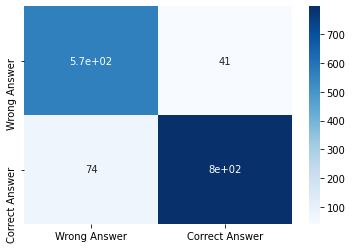

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
from pandas import DataFrame
columns = ["Wrong Answer", "Correct Answer"]

confm = confusion_matrix(y_teststring,y_predstring)
df_cm = DataFrame(confm, index=columns, columns= columns)

ax = sn.heatmap(df_cm, cmap='Blues', annot=True)

In [ ]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)